# MNIST CLASSIFICATION WITH LOW-LEVEL TF API

This is a demonstration of the low level Tensorflow API as applied to the popular MNIST dataset. The following uses low level operations to build a simple  3-layer DNN that classifies 28x28 images of hand-written digits from MNIST. 

We leverage the tensorflow example module to import the MNIST images as flattened vectors for easy processing. Batches of images are processed for multiple epochs while classification accuracy, training loss, and validation loss are logged and saved. 

## Imports

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt

## Loading MNIST 

The MNIST dataset is loaded from tf.examples for easy handling of training and validation data batching. Note that this is deprecated and will be removed in future versions of Tensorflow. Tf.data may be used alternatively to process the dataset and create an iterator similar to the one used here. 

In [2]:
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Constructing the Graph

For this example, we will use a simple DNN with 2 hidden layers. The network assumes the input is flattened. The choices of parameters like learning rate, number of epocks, and batch size are left for the user to experiment with. 

In [3]:
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

learning_rate =0.01
n_epochs = 5
batch_size = 50

In [4]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(dtype=tf.int64, shape=(None), name="y")


The neural layers are built using the following function with weights initialized using a truncated normal distribution and biases initialized to zero. An activation function can be added to control the output of the created dense layer. 

In [5]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        W = tf.Variable(init, name="kernel")
        b= tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        Z = tf.matmul(X, W) + b
        
        if activation is not None:
            return activation(Z)
        else:
            return Z

Three layers are created to process the handwritten digit data: Two hidden layers with RELU activations and one output linear layer. The variables (w and b) are created for these layers under the name scope "dnn". 
The logits at the output of the linear layer are then fed into a built-in cross entropy loss function that passes the logits through a softmax function and converts them into probabilities. 
Tf.summary is used to log the training and validation loss. 

In [6]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name='hidden2', 
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name='outputs')
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary_1 = tf.summary.scalar("Loss_training", loss)
    loss_summary_2 = tf.summary.scalar("Loss_validation", loss)

In [7]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
acc_summary = tf.summary.scalar("Validation_Accuracy", accuracy)
file_writer = tf.summary.FileWriter("./tf_log", tf.get_default_graph())

<img src="Graph.png">

## Execution


With the graph built, we create a TF session to train the network. For multiple epochs, mini batches of the data are fed to the graph, and accuracy is evaluated for training and validation. Validation accuracy, training loss, and validation loss are logged as well. 
Finally, TF.Saver is used to save the model and its parameters in .ckpt format in a user specified path. 

In [8]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_val = accuracy.eval(feed_dict={X:mnist.validation.images, 
                                          y:mnist.validation.labels})
        
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
        
        acc_str = acc_summary.eval(feed_dict={X:mnist.validation.images, 
                                          y:mnist.validation.labels})
        tr_loss_str = loss_summary_1.eval(feed_dict={X:X_batch, y:y_batch})
        ts_loss_str = loss_summary_2.eval(feed_dict={X:mnist.validation.images, 
                                          y:mnist.validation.labels})
        
        file_writer.add_summary(acc_str, epoch)
        file_writer.add_summary(tr_loss_str, epoch)
        file_writer.add_summary(ts_loss_str, epoch)

        
    save_path = saver.save(sess, "./my_model_final_ckpt")
        
file_writer.close()

0 Train accuracy: 0.92 Val accuracy: 0.9136
1 Train accuracy: 0.92 Val accuracy: 0.9304
2 Train accuracy: 0.94 Val accuracy: 0.9378
3 Train accuracy: 0.94 Val accuracy: 0.9448
4 Train accuracy: 0.94 Val accuracy: 0.9516


With a training accuracy of 94% and validation accuracy of 95.16%, we proceed to evaluating how the network performs on novel testing images. A random testing image is chosen and plotted. The model checkpoint is then restored and fed the test image. 
At the output of the network, the logits are computed and the max logit (corresponding to the highest probability) is chosen to label the input test image. 

INFO:tensorflow:Restoring parameters from ./my_model_final_ckpt
The predicted label is  7


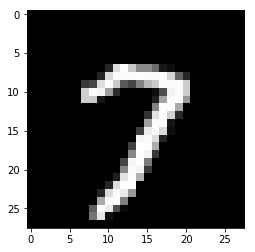

In [9]:
new_img = np.random.randint(0, mnist.test.images.shape[0])
plt.imshow(mnist.test.images[new_img].reshape(28,28), cmap='gray')

with tf.Session() as sess:
   saver.restore(sess, "./my_model_final_ckpt")
   X_new_scaled = mnist.test.images[new_img]
   y_new_scaled = mnist.test.labels[new_img]
   Z = logits.eval(feed_dict={X: X_new_scaled.reshape(-1,784)})
   y_pred = np.argmax(Z, axis=1)

print('The predicted label is ', y_pred[0]) 